---
<h1><center> BrainStation Capstone - NLP & Sentiment Analysis</center></h1>

--- 

In [0]:
# For Google Drive, mounting your local hard drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Pyspark in Google Colab

In [0]:
# Installing Pyspark in Google Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.iweb.ca/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark

# Java
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

# Initiating spark session 
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Packages Used

In [0]:
import numpy as np
import pandas as pd
import time
from operator import add

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Initiating spark context
from pyspark import SparkConf
from pyspark import SparkContext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

# For SQL
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import *

# For NLP
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel
from pyspark.ml.feature import IDF, IDFModel
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel
from pyspark.ml.linalg import DenseVector
from wordcloud import WordCloud

# For feature extraction
from pyspark.ml.feature import *

# Modeling
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import TrainValidationSplit


# Loading Data

In [0]:
data_path = '/content/drive/My Drive/BrainStation/Data Science FT/7 - Capstone/Data/'
model_path = '/content/drive/My Drive/BrainStation/Data Science FT/7 - Capstone/Model/'

In [0]:
restaurant_all_df = spark.read.format("csv").option("header", "true").load(data_path + "/TO_restaurant.csv")
user_df = spark.read.format("csv").option("header", "true").load(data_path + "/TO_user.csv")
review_df = spark.read.format("csv").option("header", "true").load(data_path + "/TO_review.csv")

In [0]:
review_df = review_df.dropna()

In [0]:
restaurant_df = restaurant_all_df.select("business_id","name","categories","restaurants_star","review_count",
                                    "latitude","longitude")

In [0]:
# Changing the column types of the dataframe to the appropriate ones: 
restaurant_df = restaurant_df.withColumn("latitude", restaurant_df.latitude.cast('float'))
restaurant_df = restaurant_df.withColumn("longitude", restaurant_df.longitude.cast('float'))
restaurant_df = restaurant_df.withColumn("restaurants_star", restaurant_df.restaurants_star.cast('float'))
restaurant_df = restaurant_df.withColumn("review_count", restaurant_df.review_count.cast('integer'))

user_df = user_df.withColumn("user_average_stars", user_df.user_average_stars.cast('float'))
user_df = user_df.withColumn("user_review_count", user_df.user_review_count.cast('integer'))
user_df = user_df.withColumn("fans", user_df.fans.cast('integer'))

review_df = review_df.withColumn("review_stars", review_df.review_stars.cast('integer'))

# Text Preprocessing

These are the text preprocessing pipelines: 

1.   Concatenate all review texts together for each business
2.   Tokenize concatenated text
1.   Remove stop words from the tokens
2.   Perform some topic modeling

In [0]:
# Create SQL view
review_df.createOrReplaceTempView("reviews")

# Create review dataframe 
review_text = spark.sql("SELECT business_id, text FROM reviews")
review_text.show(3)

# Concatenating all review texts for each restaurant
review_text_rdd = review_text.rdd
review_concat_rdd = review_text_rdd.map(tuple).reduceByKey(add)  
review_concat_df = spark.createDataFrame(review_concat_rdd)
review_concat_df = review_concat_df \
                            .withColumnRenamed('_1', 'business_id') \
                            .withColumnRenamed('_2', 'text')
review_concat_df.count()   

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|NDuUMJfrWk52RA-H-...|Pretty solid vega...|
|NDuUMJfrWk52RA-H-...|"What a great spo...|
|NDuUMJfrWk52RA-H-...|I really do love ...|
+--------------------+--------------------+
only showing top 3 rows



7965

In [0]:
# Tokenize review texts

regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')

review_concat_token_df = regexTokenizer.transform(review_concat_df)
review_concat_token_df.show(3)


+--------------------+--------------------+--------------------+
|         business_id|                text|               token|
+--------------------+--------------------+--------------------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|
|gyFYZV4b_9TxG1ulQ...|I have eaten midd...|[i, have, eaten, ...|
|aql8K6zVoJDGRJ3P-...|I had delivery, f...|[i, had, delivery...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



In [0]:
# Remove stop words

stopWordsRemover = StopWordsRemover(inputCol = 'token', outputCol = 'nostopword')

review_concat_token_clean_df = stopWordsRemover.transform(review_concat_token_df)
review_concat_token_clean_df.show(3)

+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|          nostopword|
+--------------------+--------------------+--------------------+--------------------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|
|gyFYZV4b_9TxG1ulQ...|I have eaten midd...|[i, have, eaten, ...|[eaten, middle, e...|
|aql8K6zVoJDGRJ3P-...|I had delivery, f...|[i, had, delivery...|[delivery, food, ...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



# Text Features

## TF-IDF

In [0]:
'''
# Create vectors using count-vectorizer 

countVectorizer = CountVectorizer(inputCol="nostopword", outputCol="raw_vec")

# Train the model
cv_model = countVectorizer.fit(review_concat_token_clean_df)

# Save the model
cv_model.write().overwrite().save(model_path + 'cv_model')

'''

# Load the previously trained CV model
cv_model = CountVectorizerModel.load(model_path + 'cv_model')
review_concat_vector_df = cv_model.transform(review_concat_token_clean_df)

# Get the vocabularies for all the words
vocab = cv_model.vocabulary
review_concat_vector_df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|          nostopword|             raw_vec|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|(179949,[0,1,2,3,...|
|gyFYZV4b_9TxG1ulQ...|I have eaten midd...|[i, have, eaten, ...|[eaten, middle, e...|(179949,[0,1,2,3,...|
|aql8K6zVoJDGRJ3P-...|I had delivery, f...|[i, had, delivery...|[delivery, food, ...|(179949,[0,1,2,3,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [0]:
'''
# Create features using TF-IDF
iDF = IDF(inputCol="raw_vec", outputCol="idf_vec")
idf_model = iDF.fit(review_concat_vector_df)

# Save the model
idf_model.write().overwrite().save(model_path + 'idf_model')
'''

'\n# Create features using TF-IDF\niDF = IDF(inputCol="raw_vec", outputCol="idf_vec")\nidf_model = iDF.fit(review_concat_vector_df)\n\n# Save the model\nidf_model.write().overwrite().save(model_path + \'idf_model\')\n'

In [0]:
# Load the previously trained cv model and transform 
idf_model = IDFModel.load(model_path + 'idf_model')

review_concat_idf_df = idf_model.transform(review_concat_vector_df) 
review_concat_idf_df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|          nostopword|             raw_vec|             idf_vec|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|
|gyFYZV4b_9TxG1ulQ...|I have eaten midd...|[i, have, eaten, ...|[eaten, middle, e...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|
|aql8K6zVoJDGRJ3P-...|I had delivery, f...|[i, had, delivery...|[delivery, food, ...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



## Word2Vec

In [0]:
'''
# Create Word2Vec model from the tokenized and cleaned words
  
word2vec = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'nostopword', outputCol = 'word_vec')
word2vec_model = word2vec.fit(review_concat_token_clean_df)

# save the word2vec model
word2vec_model.write().overwrite().save(model_path + 'word2vec')

'''

# Loading the trained Word2Vec model
word2vec_model = Word2VecModel.load(model_path + 'word2vec')
review_concat_w2v_df = word2vec_model.transform(review_concat_idf_df)
review_concat_w2v_df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|          nostopword|             raw_vec|             idf_vec|            word_vec|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.0675998900986...|
|gyFYZV4b_9TxG1ulQ...|I have eaten midd...|[i, have, eaten, ...|[eaten, middle, e...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.0608993525367...|
|aql8K6zVoJDGRJ3P-...|I had delivery, f...|[i, had, delivery...|[delivery, food, ...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.1066748582968...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

In [0]:
review_concat_w2v_df.limit(5).toPandas()

,business_id,text,token,nostopword,raw_vec,idf_vec,word_vec
0,NPHZkn1e-tSJAbo8Zm9rYw,"After spending the day at Woodbine Beach, I wa...","[after, spending, the, day, at, woodbine, beac...","[spending, day, woodbine, beach, looking, good...","(21.0, 22.0, 25.0, 11.0, 10.0, 17.0, 11.0, 8.0...","(1.237887398651592, 1.2208008446785923, 1.1462...","[-0.06759989009862649, -0.07963302515526872, -..."
1,gyFYZV4b_9TxG1ulQNi0Ig,I have eaten middle eastern food all over Toro...,"[i, have, eaten, middle, eastern, food, all, o...","[eaten, middle, eastern, food, toronto, came, ...","(54.0, 19.0, 25.0, 7.0, 33.0, 17.0, 15.0, 8.0,...","(3.183139025104093, 1.0543280022224206, 1.1462...","[-0.060899352536725584, -0.03644919138593802, ..."
2,aql8K6zVoJDGRJ3P-IgtpQ,"I had delivery, food came 30 minutes after cal...","[i, had, delivery, food, came, 30, minutes, af...","[delivery, food, came, 30, minutes, call, 40, ...","(15.0, 18.0, 7.0, 11.0, 5.0, 4.0, 3.0, 6.0, 1....","(0.884205284751137, 0.9988370547370301, 0.3209...","[-0.10667485829688618, -0.019265626934349387, ..."
3,Kxbn0XLcCgQqmkdIkhuOeQ,I've been here three times now and every singl...,"[i, ve, been, here, three, times, now, and, ev...","[ve, three, times, every, single, time, compla...","(1.0, 3.0, 2.0, 0.0, 0.0, 4.0, 1.0, 2.0, 1.0, ...","(0.058947018983409136, 0.16647284245617167, 0....","[-0.08563721686238371, -0.09018761411124021, -..."
4,1HRSElW1HgBiTtSNrhjMeA,Not worth it. My friend and I both felt sick a...,"[not, worth, it, my, friend, and, i, both, fel...","[worth, friend, felt, sick, ordering, take, su...","(5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","(0.2947350949170457, 0.0, 0.04585072756506684,...","[-0.052364615983096885, -0.045909583915025, -0..."


Let's test the Word2Vec model using some keywords: 

In [0]:
word2vec_model.findSynonyms('chinese', 5).show()

+---------+------------------+
|     word|        similarity|
+---------+------------------+
|cantonese|0.7521889209747314|
| mainland|0.7464713454246521|
|    asian|0.7451890110969543|
|    hakka|0.7091664671897888|
|     indo|0.7068279981613159|
+---------+------------------+



In [0]:
word2vec_model.findSynonyms('good', 5).show()

+-------+------------------+
|   word|        similarity|
+-------+------------------+
| decent|0.7440916299819946|
|  great|0.6975813508033752|
|  tasty|0.5930055975914001|
|goodthe|0.5886368155479431|
|amazing|0.5411504507064819|
+-------+------------------+



In [0]:
word2vec_model.findSynonyms('tacos', 5).show()

+----------+------------------+
|      word|        similarity|
+----------+------------------+
|      taco|0.8694519996643066|
|      baja|  0.79790860414505|
|  carnitas|0.7880722880363464|
|  tostadas|0.7773277759552002|
|enchiladas|0.7730686664581299|
+----------+------------------+



## Topic Modelling (LDA)

In [0]:
# Let's create an index for the vectors dataframe
row_with_index = Row(*["id"] + review_concat_w2v_df.columns)

def make_row(columns):
    def _make_row(row, uid):
        row_dict = row.asDict()
        return row_with_index(*[uid] + [row_dict.get(c) for c in columns])

    return _make_row

f = make_row(review_concat_w2v_df.columns)

indexed = (review_concat_w2v_df.rdd
           .zipWithUniqueId()
           .map(lambda x: f(*x))
           .toDF(StructType([StructField("id", LongType(), False)] + review_concat_w2v_df.schema.fields)))

In [0]:
# Prepare the dataframe for fitting the LDA model
index_idf = indexed.select('id','idf_vec')
index_idf = indexed.selectExpr("id as id","idf_vec as features")
index_idf.show()
index_idf.printSchema()

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|(179949,[0,1,2,3,...|
|  3|(179949,[0,1,2,3,...|
|  6|(179949,[0,1,2,3,...|
|  9|(179949,[0,1,2,5,...|
| 12|(179949,[0,2,3,4,...|
| 15|(179949,[0,1,2,3,...|
| 18|(179949,[0,1,2,3,...|
| 21|(179949,[0,1,2,3,...|
| 24|(179949,[0,1,2,3,...|
| 27|(179949,[0,1,2,3,...|
| 30|(179949,[0,1,2,3,...|
| 33|(179949,[0,1,2,3,...|
| 36|(179949,[0,1,2,3,...|
| 39|(179949,[0,1,2,3,...|
| 42|(179949,[0,2,3,5,...|
| 45|(179949,[1,2,3,7,...|
| 48|(179949,[0,1,2,3,...|
| 51|(179949,[0,1,2,3,...|
| 54|(179949,[0,1,2,3,...|
| 57|(179949,[0,1,2,3,...|
+---+--------------------+
only showing top 20 rows

root
 |-- id: long (nullable = false)
 |-- features: vector (nullable = true)



In [0]:
'''
# Define the model
lda = LDA(k=10, maxIter=10)

# Fit the model
lda_model_idf = lda.fit(index_idf)

# Save the LDA model
lda_model_idf.write().overwrite().save(model_path + 'lda_idf')

'''

# Load the previously trained LDA model
lda_model_idf = LocalLDAModel.load(model_path + 'lda_idf')

In [0]:
# Show the topics

topics = lda_model_idf.describeTopics(maxTermsPerTopic=10)
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):

    print("---------")
    
    topic_words = ''
    
    for word in topic:
        topic_words = topic_words + ' ' + word
    print("topic: "+ str(idx) + ': ' + topic_words)

---------
topic: 0:  dumplings sum jerk dim congee dumpling chinese chinatown caribbean oxtail
---------
topic: 1:  pizza burger brunch fries coffee burrito patio breakfast sandwich thai
---------
topic: 2:  ethiopian injera campagnolo sum burrata momos grapes dim tibetan marrow
---------
topic: 3:  sushi ramen pho sashimi japanese rolls noodles ayce roll rice
---------
topic: 4:  burger brisket burgers fries ribs priest pasta smoked wine gras
---------
topic: 5:  irish benihana dakgalbi teppanyaki scallywags asl sushi pub wings pizza
---------
topic: 6:  sum dim noodle sushi rol yunnan ramen rice filipino chinese
---------
topic: 7:  tacos mexican taco pastor ribs bbq arepa turkish guacamole tortillas
---------
topic: 8:  kothu filipino ramen canoe ribs view empanadas brisket pork mistura
---------
topic: 9:  pizza boil hoof captain crawfish marrow foie sushi captains charcuterie


## Restaurant Summary

In [0]:
# Adding the token counts

token_len = udf(lambda s: len(s), IntegerType())

review_concat_w2v_df = review_concat_w2v_df \
                      .withColumn("token_cnt", token_len(review_concat_w2v_df.nostopword))
review_concat_w2v_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|         business_id|                text|               token|          nostopword|             raw_vec|             idf_vec|            word_vec|token_cnt|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.0675998900986...|     2039|
|gyFYZV4b_9TxG1ulQ...|I have eaten midd...|[i, have, eaten, ...|[eaten, middle, e...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.0608993525367...|     2556|
|aql8K6zVoJDGRJ3P-...|I had delivery, f...|[i, had, delivery...|[delivery, food, ...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.1066748582968...|      919|
|Kxbn0XLcCgQqmkdIk...|I've been here th...|[i,

In [0]:
# Create restaurant summary dataframe
a = review_concat_w2v_df.alias("a")
b = restaurant_df.alias("b")
    
summary_df = a.join(b, a.business_id == b.business_id)\
             .select([col('a.'+xx) for xx in a.columns] + [col('b.name'),col('b.categories'),
                                                           col('b.restaurants_star'),col('b.review_count'),
                                                           col('b.latitude'),col('b.longitude')])
summary_df.show(10)    

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+------------+---------+----------+
|         business_id|                text|               token|          nostopword|             raw_vec|             idf_vec|            word_vec|token_cnt|                name|          categories|restaurants_star|review_count| latitude| longitude|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+------------+---------+----------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.0675998900986...|     2039|    Burrito Bandidos|Tex-Mex, Mexican,...|             3.5|          43| 43.66618| -79

# Word Cloud Analysis

In [0]:
def word_cloud(text):
    
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
# Word cloud for 5 top restaurants in Toronto

summary_df.select('business_id', 'name', 'categories') \
        .filter((summary_df.restaurants_star == 5) & (summary_df.review_count > 50)) \
        .show(5, truncate=False)


+----------------------+--------------------------------+-----------------------------------------------+
|business_id           |name                            |categories                                     |
+----------------------+--------------------------------+-----------------------------------------------+
|J9vAdD2dCpFuGsxPIn184w|New Orleans Seafood & Steakhouse|Steakhouses, Cajun/Creole, Restaurants, Seafood|
|g6AFW-zY0wDvBl9U82g4zg|Baretto Caffe                   |Restaurants, Italian, Cafes                    |
|VUADGMPLJoWqhHb1G4LIcA|Veghed                          |Restaurants, Vegan, Vegetarian                 |
|JB8-8TtNYX-vLqN7cz-zHA|Zeal Burgers                    |Restaurants, Burgers                           |
+----------------------+--------------------------------+-----------------------------------------------+



Restaurant: New Orleans Seafood & Steakhouse


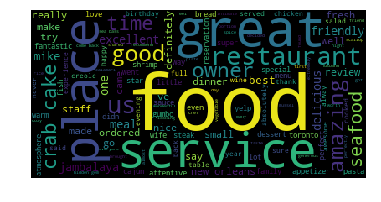

Restaurant: Baretto Caffe


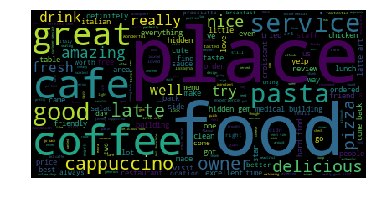

Restaurant: Veghed


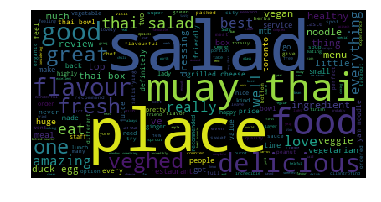

Restaurant: Zeal Burgers


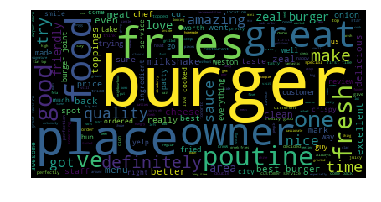

In [0]:
# Return a list of restaurants name in Toronto with 5 star-rating and review_count > 50
r_name = summary_df.select('name') \
        .filter((summary_df.restaurants_star == 5) & (summary_df.review_count > 50)) \
        .rdd.flatMap(lambda x: x).collect()

# Plot the word cloud in a loop
for i in range(len(r_name)): 
  texts = ' '.join(summary_df.select('nostopword') \
                           .filter(summary_df.name == r_name[i]).rdd.take(1)[0][0])
  print(f'Restaurant: {r_name[i]}')
  word_cloud(texts)

In [0]:
summary_df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+------------+---------+---------+
|         business_id|                text|               token|          nostopword|             raw_vec|             idf_vec|            word_vec|token_cnt|                name|          categories|restaurants_star|review_count| latitude|longitude|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+------------+---------+---------+
|NPHZkn1e-tSJAbo8Z...|After spending th...|[after, spending,...|[spending, day, w...|(179949,[0,1,2,3,...|(179949,[0,1,2,3,...|[-0.0675998900986...|     2039|    Burrito Bandidos|Tex-Mex, Mexican,...|             3.5|          43| 43.66618|-79.316

# Similarity Score

In [0]:
# Define similarity function

def CosineSim(vec1, vec2):
  
  """
  return: cosine similarity score beteen two input vectors
  
  """
  return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1)) / np.sqrt(np.dot(vec2, vec2)) 

In [0]:
def CheckSimilarity(r_id1, r_id2):
    
  """
  Compare IDF / Word2Vec similarity score
  
  """
    
  summary_df.select('name', 'business_id', 'categories') \
        .filter(summary_df.business_id.isin(r_id1 , r_id2)) \
        .show(truncate=False)
        
  r_id1_review_text = ' '.join(summary_df.select('nostopword') \
                                .filter(summary_df.business_id == r_id1).rdd.take(1)[0][0])
  r_id2_review_text = ' '.join(summary_df.select('nostopword') \
                                .filter(summary_df.business_id == r_id2).rdd.take(1)[0][0])
    
  word_cloud(r_id1_review_text)
  word_cloud(r_id2_review_text)
    
  # Cosine similarity based on IDF vectors
  vec_r_id1 = summary_df.select('idf_vec').filter(summary_df.business_id == r_id1).rdd.take(1)[0][0]
  vec_r_id2 = summary_df.select('idf_vec').filter(summary_df.business_id == r_id2).rdd.take(1)[0][0]
  
  # Convert sparse vectors to dense vectors for IDF 
  vec1 = DenseVector(vec_r_id1.toArray())
  vec2 = DenseVector(vec_r_id2.toArray())
  print('Cosine similarity for TFIDF vectors: ' + str(CosineSim(vec1, vec2)))
    
  # get cosine similarity based on Word2Vec vectors
  vec1 = summary_df.select('word_vec').filter(summary_df.business_id == r_id1).rdd.take(1)[0][0]
  vec2 = summary_df.select('word_vec').filter(summary_df.business_id == r_id2).rdd.take(1)[0][0]
  print('Cosine similarity for Word2Vec vectors: ' + str(CosineSim(vec1, vec2)))
    
    

In [0]:
restaurant_df.where(col('categories').like("%Sushi%")).limit(5).toPandas()

,business_id,name,categories,restaurants_star,review_count,latitude,longitude
0,aql8K6zVoJDGRJ3P-IgtpQ,Ume Fashion Sushi,"Sushi Bars, Restaurants",4.5,25,43.692791,-79.262627
1,SJBzyJDCR_f6dx5tpYAABA,Kibo Sushi House,"Sushi Bars, Japanese, Restaurants",4.0,15,43.600521,-79.505516
2,2aIgbnGUg8VC0u9iXO-wnQ,O Sushi,"Sushi Bars, Food, Restaurants",3.5,46,43.666626,-79.316811
3,oU-Af-_1zT-ewuLfIubN2w,Katsu Japanese Restaurant,"Japanese, Restaurants, Sushi Bars",3.0,86,43.678696,-79.347054
4,p82Oz-NOHn-MAZQ0jQBkNg,Riki Sushi,"Sushi Bars, Restaurants, Japanese, Asian Fusion",4.0,11,43.662418,-79.422874


+-----------------+----------------------+---------------------------------+
|name             |business_id           |categories                       |
+-----------------+----------------------+---------------------------------+
|Ume Fashion Sushi|aql8K6zVoJDGRJ3P-IgtpQ|Sushi Bars, Restaurants          |
|Kibo Sushi House |SJBzyJDCR_f6dx5tpYAABA|Sushi Bars, Japanese, Restaurants|
+-----------------+----------------------+---------------------------------+



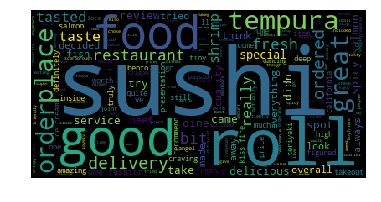

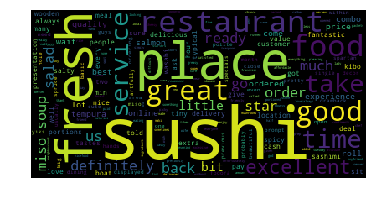

Cosine similarity for TFIDF vectors: 0.551772856429998
Cosine similarity for Word2Vec vectors: 0.8810523751620473


In [0]:
# Check on restaurants that are actually similar to each other 
bid1 = 'aql8K6zVoJDGRJ3P-IgtpQ' 
bid2 = 'SJBzyJDCR_f6dx5tpYAABA'

CheckSimilarity(bid1, bid2)

+--------------------------------------+----------------------+------------------------------------------------------------------------------------------+
|name                                  |business_id           |categories                                                                                |
+--------------------------------------+----------------------+------------------------------------------------------------------------------------------+
|Rawlicious                            |-hXocgx4xqs9dv_l0jiZZg|Food, Vegan, Juice Bars & Smoothies, Salad, Gluten-Free, Vegetarian, Desserts, Restaurants|
|The Keg Steakhouse + Bar - York Street|gy5pr5bFAjOL5rERSdMCLg|Restaurants, Steakhouses, Nightlife, Seafood, Bars                                        |
+--------------------------------------+----------------------+------------------------------------------------------------------------------------------+



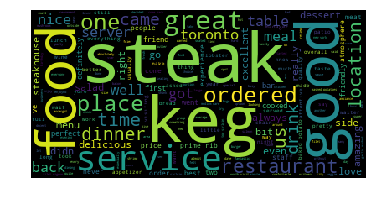

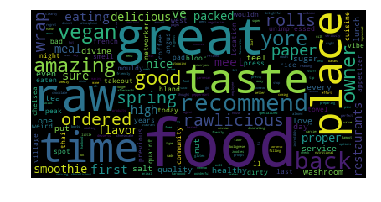

Cosine similarity for TFIDF vectors: 0.0273457764494819
Cosine similarity for Word2Vec vectors: 0.6985600752412429


In [0]:
# Check on restaurants that are completely opposite of each other

bid1='gy5pr5bFAjOL5rERSdMCLg'
bid2='-hXocgx4xqs9dv_l0jiZZg'

CheckSimilarity(bid1, bid2)

Looks like Word2Vec always give higher similarity score than IDF. 